In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
!pip install pyro-ppl
import pyro.distributions as dist
import pyro
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.nuts import HMC

from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.6 MB/s eta 0:00:00


Outline:

1. Neural network, its cons, study case
2. Bayesian neural network to the rescue, study case
3. Uncertainty estimation

Jaringan saraf tiruan atau *artificial neural network* merupakan metode yang powerful dalam memodelkan berbagai proses alam. Salah satu point yang membuat metode ini banyak digunakan adalah kemampuannya meodelkan proses tak linier

Sebagai contoh, didapatkan sekumpulan data yang ditunjukkan oleh gambar dibawah

Text(0, 0.5, 'y')

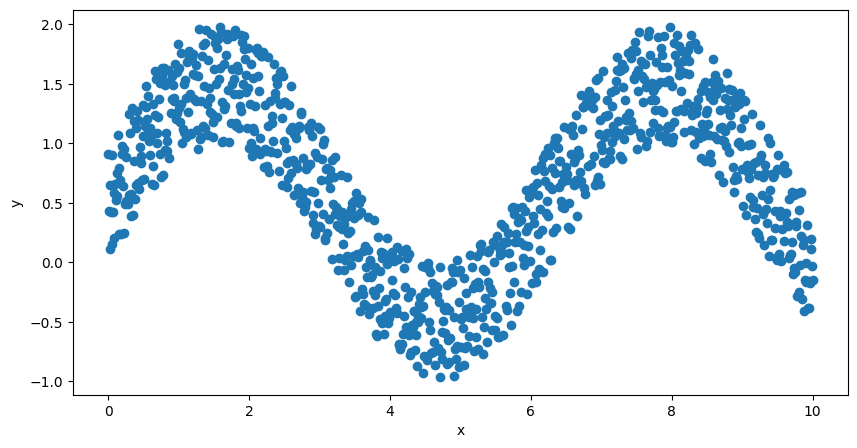

In [ ]:
rng = np.random.RandomState(1)
x = np.linspace(0, 10, 1000)
error = np.random.random(1000)
y = np.sin(x) + error

fig, ax = plt.subplots(figsize=(10, 5));
plt.scatter(x, y);
plt.xlabel('x');
plt.ylabel('y');

Secara sekilas, regresi data $y$ pada $x$ mengikuti fungsi sinusoidal. Fungsi sinusoidal adalah fungsi tak linier. Akan sukar untuk meregresi data tersebut dengan cara konvensional.

Dalam permasalahan ini, *neural network* dapat digunakan untuk meregresi fungsi tak linier. Apabila regresi dilakukan dengan menggunakan *neural network* pada sekumpulan data di atas, akan didapatkan hasil regresi seperti pada gambar di bawah.

In [ ]:
class NN(torch.nn.Module):
  def __init__(self):
    super(NN, self).__init__()

    self.layer1 = nn.Linear(1, 100)
    self.layer2 = nn.Linear(100, 64)
    self.layer3 = nn.Linear(64, 32)
    self.layer4 = nn.Linear(32, 8)
    self.layer5 = nn.Linear(8, 5)
    self.output = nn.Linear(5, 1)

  def forward(self, x):
    output = torch.relu(self.layer1(x))
    output = torch.relu(self.layer2(output))
    output = torch.relu(self.layer3(output))
    output = torch.relu(self.layer4(output))
    output = torch.relu(self.layer5(output))
    output = self.output(output)
    return output

In [ ]:
# Define the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = NN().to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

cpu
NN(
  (layer1): Linear(in_features=1, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=8, bias=True)
  (layer5): Linear(in_features=8, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=1, bias=True)
)


In [ ]:
n_epochs = 1000

x_train = torch.from_numpy(x.reshape(-1,1)).float()
y_train = torch.from_numpy(y.reshape(-1,1)).float()

loss_values = []

for epoch in range(n_epochs):
  y_pred = model(x_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f'Finished epoch {epoch}, latest loss {loss}')
  loss_values.append(loss.item())

Finished epoch 0, latest loss 0.8006971478462219
Finished epoch 100, latest loss 0.2347801923751831
Finished epoch 200, latest loss 0.1062050610780716
Finished epoch 300, latest loss 0.08817963302135468
Finished epoch 400, latest loss 0.08842827379703522
Finished epoch 500, latest loss 0.09014877676963806
Finished epoch 600, latest loss 0.08764666318893433
Finished epoch 700, latest loss 0.08758381009101868
Finished epoch 800, latest loss 0.08733503520488739
Finished epoch 900, latest loss 0.08907566964626312


In [ ]:
pred = []

with torch.no_grad():
    for X in x_train:
        outputs = model(X)
        pred.append(outputs)

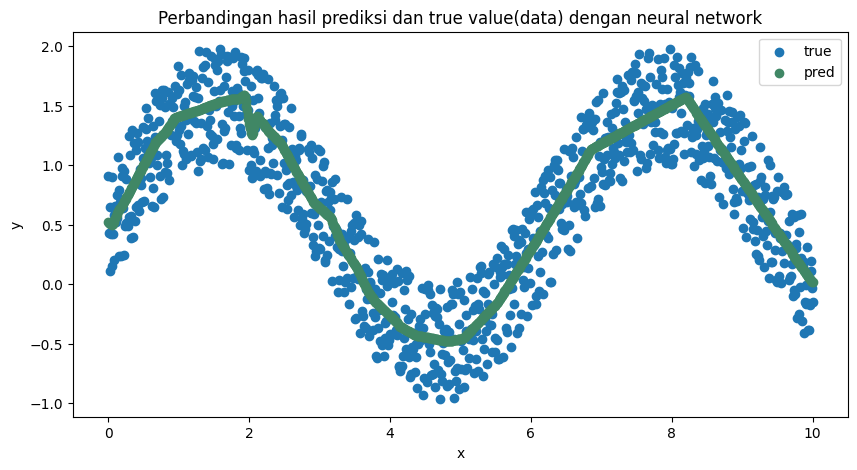

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5));
plt.scatter(x, y, label='Data');
plt.scatter(x, pred, color="#408765", label='Prediction');
plt.title('Perbandingan hasil prediksi dan true value(data) dengan neural network');
plt.xlabel('x');
plt.ylabel('y');
plt.legend();

Untuk beberapa kasus, hasil di atas sudah dapat dipertanggungjawabkan. Salah satu caranya dengan memperlihatkan perbandingan visualisasi prediksi dan data atau dengan menghitung error atau residu dari model.

Namun, untuk beberapa kasus dimana diperlukan quantifikasi ketidakpastian atau interval kepercayaan (*confidence interval*) atau penjelasan bagaimana satu variabel dengan variabel yang lain saling berinteraksi, *neural network* mungkin bukan metode yang tepat.

Inilah mengapa *neural network* disebut dengan *black box*.

Disinilah keuntungan penggunaan *Bayesian neural network* dibanding *neural network*. *Bayesian neural network* mengestimasi bobot dari jaringan dengan menggunakan fungsi kepadatan probabilitas sehingga ketidakpastian bobot dapat terkuantifikasi. Kuantifikasi ketidakpastian variabel dengan fungsi kepadatan probabilitas mengijinkan adanya penjelasan-penjelasan lain seperti *confidence interval* dari prediksi atau interaksi satu variabel dengan variabel lain.

Dalam python, Pyro adalah library yang memungkinkan pembuatan model *Bayesian neural network*.

Untuk kasus yang sama dengan *neural network* di atas, kita dapat membangun ekuivalensinya dengan Pyro.

In [ ]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.ReLU()
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [ ]:
# define model and data
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train.reshape(-1), y_train.reshape(-1))

Sample: 100%|██████████| 100/100 [10:42,  6.42s/it, step size=1.17e-03, acc. prob=0.775]


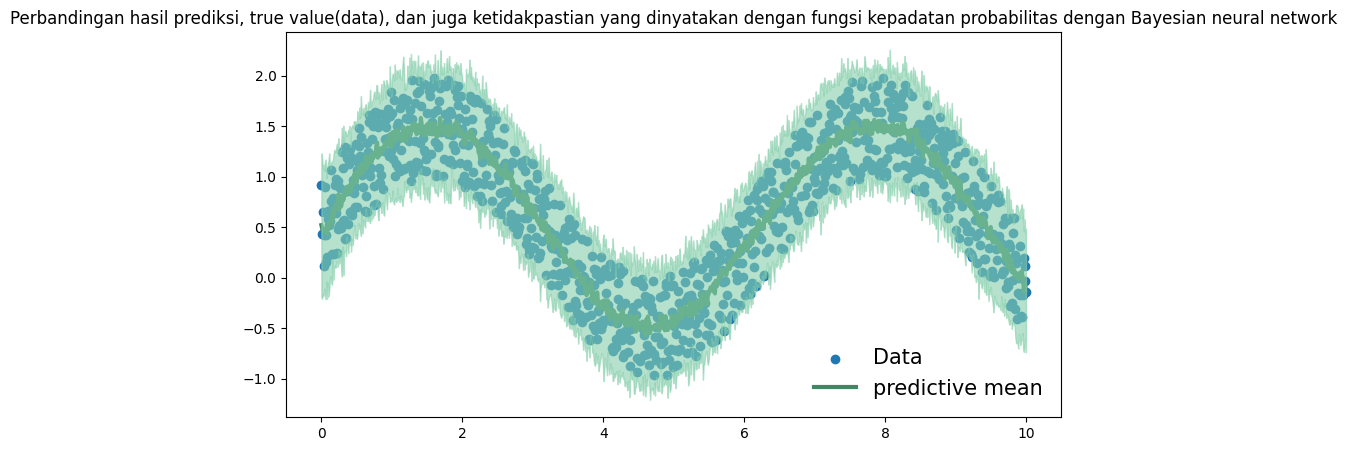

In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_train.reshape(-1))

fig, ax = plt.subplots(figsize=(10, 5))
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

ax.scatter(x, y, label="Data");
ax.plot(x_train.reshape(-1), y_pred, '-', linewidth=3, color="#408765", label="Predictive mean");
ax.fill_between(x_train.reshape(-1), y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5);
plt.title('Perbandingan hasil prediksi, true value(data), dan juga ketidakpastian yang dinyatakan dengan fungsi kepadatan probabilitas dengan Bayesian neural network');
plt.legend(loc=4, fontsize=15, frameon=False);

Selain prediksi yang dihasilkan *Bayesian neural network* berupa fungsi kepadatan probabilitas, setiap bobot, bias, atau parameter-parameter yang ada di *neural network* juga dimodelkan dengan fungsi kepadatan probabilitas.

In [ ]:
samples = mcmc.get_samples()

In [ ]:
weight_layer5_samples = []
bias_layer3_samples = []

for i in range(np.shape(samples["layers.5.weight"])[0]):
  weight_layer5_samples.append(samples["layers.5.weight"][i][0][0].numpy())
  bias_layer3_samples.append(samples["3.bias"][i][5].numpy())

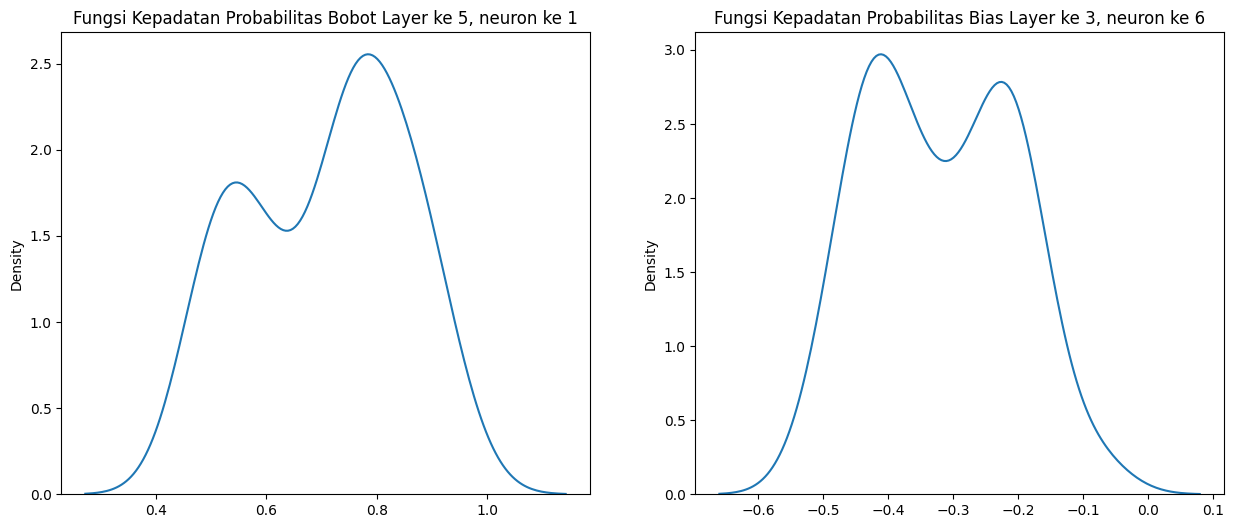

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.kdeplot(np.reshape(weight_layer5_samples, (-1)), ax=axs[0])
sns.kdeplot(np.reshape(bias_layer3_samples, (-1)), ax=axs[1])
axs[0].title.set_text('Fungsi Kepadatan Probabilitas Bobot Layer ke 5, neuron ke 1')
axs[1].title.set_text('Fungsi Kepadatan Probabilitas Bias Layer ke 3, neuron ke 6')

Seperti yang telah ditunjukkan, kelebihan *Bayesian neural network* ada pada kemampuannya untuk mengestimasi bobot jaringan menggunakan fungsi kepadatan probabilitas. Hal ini memungkinkan pengguna untuk merancang sebuah model dan melihat efek satu neuron terhadap neuron lain sehingga mengurangi sifat *black box* pada *neural network*. Bidang ini disebut *explainable machine learning*.

Masih banyak yang perlu dikembangkan dalam *Bayesian neural network*. Salah satu alasan belum digunakannya *Bayesian neural network* secara luas adalah waktu yang digunakan untuk melatih model relatif lebih lama dibanding *neural network* biasa. Riset mengenai algoritma pengestimasi untuk mengurangi waktu latih menjadi potensi yang menggiurkan.

Regardless, poin utama pengunaan *Bayesian neural network* adalah: alih-alih mengestimasi suatu variabel atau parameter menjadi satu nilai estimasi, *Bayesian nerual network* menghasilkan fungsi kepadatan untuk setiap variabel atau parameter. Hal ini memungkinkan pembuatan model yang memperhitungkan ketidakpastian model.